In [26]:

import os

API_KEY=os.environ['MAP_TOKEN']
modelname="unet-128-single-model-6ch-loss-dice-rms-met-acc-iou-512-layers"
mask_directories = ["BUILDING", "ROAD", "WATER", "NONE", "FOREST", "LAND"]

import tensorflow as tf
from tensorflow.keras.layers import Input,Conv2D,ReLU,UpSampling2D,MaxPool2D,Dropout,BatchNormalization,Layer,Activation
from tensorflow.keras import Model,mixed_precision,models
from tensorflow.keras.activations import sigmoid,tanh,leaky_relu
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint,Callback
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanIoU,CategoricalCrossentropy
import numpy as np
import pandas as pd
# import cv2
import matplotlib.pyplot as plt
import matplotlib.colors as colors

In [27]:


def dice_loss_w_rms(y_true, y_pred):
    # Flatten the predictions and ground truth

    y_true_flat = tf.reshape(y_true,  [-1, tf.reduce_prod(tf.shape(y_true)[2:])])
    # y_true_flat = tf.reshape(y_true,  [-1])
    y_pred_flat = tf.reshape(y_pred,  [-1, tf.reduce_prod(tf.shape(y_pred)[2:])])
    # y_pred_flat = tf.reshape(y_pred,  [-1])
    # print(y_true.shape)
    # print(y_true_flat.shape)
    sq_dif=tf.square(y_true_flat-y_pred_flat)
    reduce_sq_dif=tf.reduce_mean(sq_dif)
    sqrt=tf.sqrt(reduce_sq_dif)

    # Compute the intersection and union
    
    # intersection = tf.reduce_sum(y_true_flat * y_pred_flat)
    intersection = tf.reduce_sum(y_true_flat * y_pred_flat,axis=[0])+1e-6
    # union = tf.reduce_sum(y_true_flat) + tf.reduce_sum(y_pred_flat)
    union = tf.reduce_sum(y_true_flat,axis=[0]) + tf.reduce_sum(y_pred_flat,axis=[0])+1e-6
    

    # Compute the Dice loss
    dice_loss = 1 - 2 * intersection / union
    dice_loss=tf.reduce_sum(tf.math.abs(dice_loss))
    print(intersection,dice_loss)

    return dice_loss+sqrt
    # return sqrt


model=models.load_model(f"models/{modelname}.keras",custom_objects={'dice_loss_2':dice_loss_w_rms,'dice_loss_w_rms':dice_loss_w_rms,})

checkpoint = tf.train.Checkpoint( model=model)
manager = tf.train.CheckpointManager(
    checkpoint, directory=f"checkpoints/{modelname}/", max_to_keep=10)
status = checkpoint.restore(manager.latest_checkpoint)

model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 128, 128, 64)   │         6,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_8 (ReLU)                  │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 64, 64, 128)    │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_9 (ReLU)                  │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 32, 32, 256)    │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_10 (ReLU)                 │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 16, 16, 512)    │     4,719,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 16, 16, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_11 (ReLU)                 │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 8, 8, 256)      │     4,718,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 37,417,268 (142.74 MB)

 Trainable params: 12,471,462 (47.57 MB)

 Non-trainable params: 2,880 (11.25 KB)

 Optimizer params: 24,942,926 (95.15 MB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


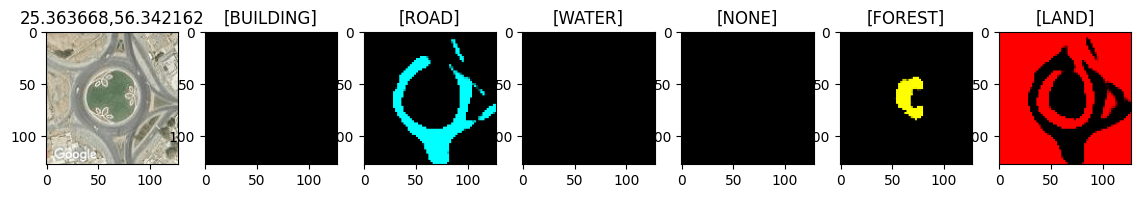

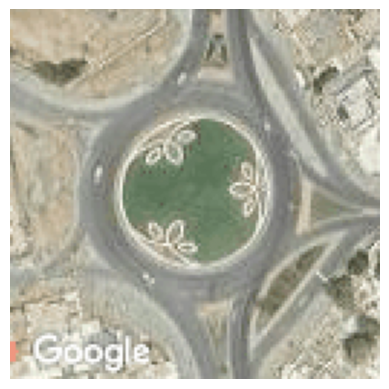

In [30]:
import requests
from PIL import Image
from io import BytesIO
cmaps=[
    colors.LinearSegmentedColormap.from_list(name='Trans2Blue', colors=[(0., 0., 0., 1.), (0., 0., 1., 1.)]),
    colors.LinearSegmentedColormap.from_list(name='Trans2Blue', colors=[(0., 0., 0., 1.), (0.,1, 1., 1.)]),
    colors.LinearSegmentedColormap.from_list(name='Trans2Blue', colors=[(0., 0., 0., 1.), (1, 0., 1., 1.)]),
    colors.LinearSegmentedColormap.from_list(name='Trans2Blue', colors=[(0., 0., 0., 1.), (0., 1., 0., 1.)]),
    colors.LinearSegmentedColormap.from_list(name='Trans2Blue', colors=[(0., 0., 0., 1.), (1., 1., 0., 1.)]),
    colors.LinearSegmentedColormap.from_list(name='Trans2Blue', colors=[(0., 0., 0., 1.), (1., 0., 0., 1.)]),
]


def show_picture_compare(original, res, name):
    global training_cnt
    main="""
        .......
        XABCDEF
        .......
        """
    fig, am = plt.subplot_mosaic(main)
    fig.set_size_inches(14,12)
    # plt.subplots_adjust(hspace=0.25)
    am["X"].set_title(f"{name.split('/')[-1]}")

    am["X"].imshow(original)    

    for k in range(0,6):
        am[chr(ord("A")+k)].imshow(res[:,:,k],cmap=cmaps[k],vmin=0.,vmax=1.)
        am[chr(ord("A")+k)].set_title(f"[{mask_directories[k]}]")
        # am[chr(ord("G")+k)].imshow(res[:,:,k],cmap=cmaps[k],vmin=0.,vmax=1.)
        # am[chr(ord("G")+k)].set_title(f"[Pred]")
        # plt.tight_layout()
    
    cmp_path=f'compare_img/{modelname}/{name.split("/")[-1].split(".")[0]}/'
    if not os.path.exists(cmp_path):
        os.makedirs(cmp_path)
    # plt.savefig(f'{cmp_path}{training_cnt}.png',bbox_inches='tight')
    
    plt.show()
    # plt.close()

def display_satellite_image(api_key, location, zoom, size):
    """
    Fetches and displays a satellite image from Google Maps Static API.

    Parameters:
        api_key (str): Your Google Maps API key.
        location (str): The location to get the satellite image for (latitude,longitude or address).
        zoom (int): The zoom level of the image (0-21).
        size (str): The size of the image in pixels (widthxheight, max 640x640 for free tier).
    """
    base_url = "https://maps.googleapis.com/maps/api/staticmap"
    params = {
        "center": location,
        "zoom": zoom,
        "size": size,
        "maptype": "satellite",
        "key": api_key
    }
    response = requests.get(base_url, params=params)
    if response.status_code == 200:
        image = Image.open(BytesIO(response.content)).convert("RGB")
        image_tensor = np.array(image)
        image_tensor=image_tensor/255

        image_tensor = tf.convert_to_tensor(image_tensor)
        result=model.predict(image_tensor[None,...])[0]
        show_picture_compare(image_tensor,result,location)
        
        # Display the image using Matplotlib
        plt.imshow(image_tensor)
        plt.axis('off')  # Turn off axis labels
        plt.show()
    else:
        print(f"Failed to get image. Status code: {response.status_code}")

# Example usage
api_key = API_KEY 
# location ="25.165604,121.392548"  # Taipei Pier
# location="25.109248,121.469391" # Shilin / Shezi
# location="25.102712,121.454953" # Wugu
# location="24.41715,54.403820" # Zhishan
location="25.363668,56.342162" # Abu Dhabi
# location = "25.363768,56.344162"
zoom = 17

size = "128x128"

display_satellite_image(api_key, location, zoom, size)
